In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import itertools

In [2]:
class Contextual_Bandit_generator:

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def __init__(self, config):
        self.state = {"X": [], "article": [], "reward": []}
        self.population = [[], []]
        self.population[0], self.population[1] = make_classification(
            n_samples=config["n_samples"],
            n_features=5,
            n_informative=5,
            n_classes=5,
            n_redundant=0,
            n_repeated=0,
            flip_y=0.2,
            shift=[10, 4, 0, 0, 0],
            scale=[7, 1, 1, 1, 1],
            random_state=8,
        )
        self.population[0] = self.feature_engineer(self.population[0])
        self.current_context = {"X": [], "best_article": []}

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def feature_engineer(self, Data):
        Data[:, 0] = (Data[:, 0] > 0) * 1
        Data[:, 1] = (Data[:, 1] > 0) * 1
        Data[:, 3][(Data[:, 3] < 0)] = 0
        Data[:, 3][(Data[:, 3] > 5)] = 5
        Data[:, 3] = np.round(Data[:, 3])
        Data[:, 4] = np.round(Data[:, 4])
        return Data

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def step(self):
        sample = np.random.choice(len(self.population[1]))
        x = self.population[0][sample]
        ba = self.population[1][sample]
        if len(self.state["X"]) == 0:
            self.state["X"] = x
        else:
            self.state["X"] = np.vstack((self.state["X"], x))
        self.current_context["X"] = x
        self.current_context["best_article"] = ba

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def reward(self, a):
        if self.current_context["best_article"] == a:
            response = np.random.binomial(n=1, p=0.9, size=1)[0]
        else:
            response = np.random.binomial(n=1, p=0.05, size=1)[0]
        if len(self.state["X"]) == 0:
            self.state["article"] = np.array(a)
            self.state["reward"] = np.array(response)
        else:
            self.state["article"] = np.append(self.state["article"], a)
            self.state["reward"] = np.append(self.state["reward"], response)

In [3]:
# intended setup
env_config = {"n_samples": 100000}
env = Contextual_Bandit_generator(env_config)

In [4]:
# intended use
env.step()
a = 2
env.reward(a)
env.state

{'X': array([ 0.        ,  1.        ,  3.24215666,  1.        , 61.        ]),
 'article': array([2.]),
 'reward': array([1.])}

## Learn about the environment
run the step function with randomly generated a for 100, 1000, 10000, and 100000 turns

In [5]:
num_turns = [100, 1000, 10000, 100000]

for num in num_turns:
    env = Contextual_Bandit_generator(env_config)
    for _ in range(num):
        env.step()
        a = np.random.randint(0, 5)
        env.reward(a)
    print(f"After {num} turns:")
    print(env.state)

After 100 turns:
{'X': array([[  0.        ,   1.        ,   3.00285778,   1.        ,
         69.        ],
       [  1.        ,   1.        ,   2.56581816,   1.        ,
         68.        ],
       [  1.        ,   1.        ,   2.86115436,   0.        ,
         65.        ],
       [  1.        ,   1.        ,   2.3567876 ,   0.        ,
         66.        ],
       [  1.        ,   1.        ,   3.96258608,   1.        ,
         59.        ],
       [  0.        ,   1.        ,   2.35271522,   0.        ,
         59.        ],
       [  1.        ,   0.        ,   3.90073147,   0.        ,
         62.        ],
       [  1.        ,   0.        ,   6.02967777,   0.        ,
        110.        ],
       [  0.        ,   0.        ,   3.53907836,   1.        ,
         73.        ],
       [  1.        ,   1.        ,   4.15247273,   1.        ,
         72.        ],
       [  1.        ,   1.        ,   3.74944432,   1.        ,
         82.        ],
       [  1.        

## Implement a simple contextual bandit
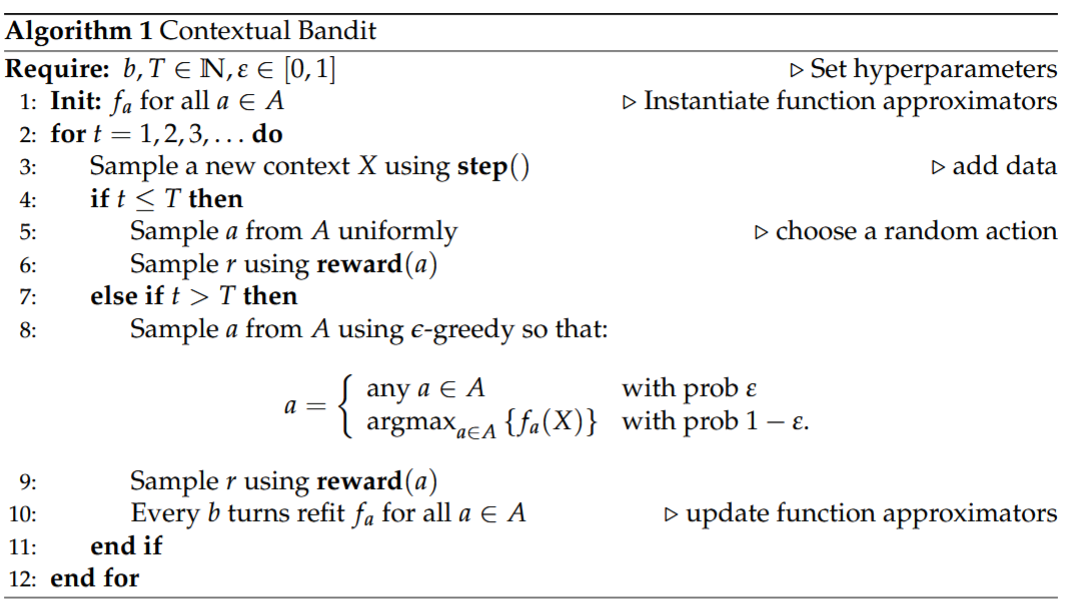

In [6]:
# hyperparameters:
# b -> refit_every: number of turns between refitting function approximators
# T ∈ N -> exploration_len: number of initial random explorations
# ε ∈ [0, 1] -> epsilon: probability of exploration after initial explorations

# function approximator:
# fa for all a ∈ A -> sklearn.ensemble.RandomForestClassifier


class Contextual_Bandit_Agent:

    def __init__(
        self,
        actions,
        func_approx=RandomForestClassifier,
    ):
        self.actions = actions
        self.func_approx = func_approx

    def fit(self, env):
        for a in self.actions:
            y = env.state["reward"][env.state["article"] == a]
            X = env.state["X"][env.state["article"] == a]
            if len(y) > 0:
                self.models[a].fit(X, y)

    def simulate(
        self, env, exploration_len, epsilon, refit_every, num_turns=10000, verbose=False
    ):
        self.models = {}
        for a in self.actions:
            self.models[a] = self.func_approx()

        for i in range(1, num_turns + 1):
            # sample context X using step
            env.step()
            # if t <= T then ...
            if i <= exploration_len:
                # sample action a uniformly from A
                a = np.random.choice(self.actions)
                # sample r using reward(a)
                env.reward(a)
                if verbose:
                    print(f"{i} Exploration: Chose random action {a}")
                if i == exploration_len:
                    self.fit(env)
                    if verbose:
                        print(
                            f"{i} Exploration: Finished initial exploration and fitted models"
                        )
            # else if t > T then ...
            else:
                # with probability ε...
                if np.random.rand() < epsilon:
                    # sample a uniformly from A
                    a = np.random.choice(self.actions)
                    env.reward(a)
                    if verbose:
                        print(f"{i} Exploration (ε): Chose random action {a}")
                # with probability 1 - ε ...
                else:
                    # select a = argmax_a' f_a'(X)
                    X = env.current_context["X"]
                    preds = []
                    for a in self.actions:
                        preds.append((a, self.models[a].predict(X.reshape(1, -1))[0]))
                    chosen_action = max(preds, key=lambda x: x[1])
                    if verbose:
                        print(
                            f"{i} Exploitation: Chose action {chosen_action[0]} with predicted reward {chosen_action[1]} "
                        )

                    # sample r using reward(a)
                    env.reward(chosen_action[0])

                if i % refit_every == 0:
                    if verbose:
                        print(f"{i} Refitting models")
                    self.fit(env)

    def evaluate(self, env):
        total_rewards = np.sum(env.state["reward"])
        average_reward = np.mean(env.state["reward"])
        return total_rewards, average_reward

## Running the algorithm

- Use T = 500. 
- Use untuned random forest binary classifiers for the function approximators.
- Compute average reward over time
  - Use 10,000 turns
  - Use b = 100 or 1000
  - Use ε = 0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5


In [7]:
# b: number of turns between refitting function approximators
# T: number of initial random explorations
# ε: probability of exploration after initial explorations
# num_turns: number of turns to simulate

T = 500
num_turns = 10000
b = [100, 1000]
e = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

actions = range(5)
bandit = Contextual_Bandit_Agent(actions)

for refit_every, epsilon in itertools.product(b, e):
    env = Contextual_Bandit_generator(env_config)
    bandit.simulate(
        env,
        T,
        epsilon,
        refit_every,
        num_turns,
    )
    total_rewards, average_reward = bandit.evaluate(env)
    print(
        f"Refit every {refit_every} turns, ε={epsilon}: Total Rewards = {total_rewards}, Average Reward = {average_reward}"
    )

Refit every 100 turns, ε=0: Total Rewards = 3134.0, Average Reward = 0.3134
Refit every 100 turns, ε=0.05: Total Rewards = 3394.0, Average Reward = 0.3394
Refit every 100 turns, ε=0.1: Total Rewards = 3553.0, Average Reward = 0.3553
Refit every 100 turns, ε=0.2: Total Rewards = 3182.0, Average Reward = 0.3182
Refit every 100 turns, ε=0.3: Total Rewards = 3367.0, Average Reward = 0.3367
Refit every 100 turns, ε=0.4: Total Rewards = 3158.0, Average Reward = 0.3158
Refit every 100 turns, ε=0.5: Total Rewards = 2936.0, Average Reward = 0.2936
Refit every 1000 turns, ε=0: Total Rewards = 3500.0, Average Reward = 0.35
Refit every 1000 turns, ε=0.05: Total Rewards = 3297.0, Average Reward = 0.3297
Refit every 1000 turns, ε=0.1: Total Rewards = 3331.0, Average Reward = 0.3331
Refit every 1000 turns, ε=0.2: Total Rewards = 3194.0, Average Reward = 0.3194
Refit every 1000 turns, ε=0.3: Total Rewards = 3122.0, Average Reward = 0.3122
Refit every 1000 turns, ε=0.4: Total Rewards = 3167.0, Average 